In [128]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from collections import Counter

In [129]:
# Constants
DATA_PATH = "/users/mik2002/som/dataset-processed/"
FILES = ["processed_bot_dataset.csv", "processed_dos_dataset.csv", "processed_bruteforce_dataset.csv"]
markers = ['s', 'v','p','d']
colors = ['green', 'magenta','yellow','cyan']

In [130]:
def load_and_combine_datasets(files, path):
    """Load and combine multiple datasets."""
    return pd.concat([pd.read_csv(path + file) for file in files],ignore_index=True)

In [131]:
def preprocess_data(df):
    """Preprocess the data for modeling."""
    df["Label"] = df["Label"].map({"Benign": 0, "Dos": 1, "Bot": 2, "Bruteforce": 3})
    scaler = MinMaxScaler()
    data = scaler.fit_transform(df.iloc[:,:-1])
    target = df.iloc[:,-1].values
    return data, target

In [132]:

def stratified_sample(df, group_column='Label', frac=0.1, random_state=42):
    """
    Calcola le proporzioni delle classi nel dataset originale e esegue un campionamento casuale stratificato.
    
    :param df: DataFrame da campionare.
    :param group_column: Colonna su cui basare il campionamento stratificato.
    :param frac: Frazione di ciascun gruppo da campionare.
    :param random_state: Seed per la generazione di numeri casuali.
    :return: DataFrame campionato.
    """
    # Calcola le proporzioni delle classi nel dataset originale
    class_proportions = df[group_column].value_counts(normalize=True)
    print("Proporzioni delle classi nel dataset originale:")
    print(class_proportions)
    
    # Esegui il campionamento casuale stratificato mantenendo le proporzioni delle classi
    sampled_df = df.groupby(group_column, group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=random_state))
    
    return sampled_df

In [133]:
def classify(som, data, training_data, training_labels):
    """
    Classifies each sample in data using the trained SOM and a labels map.
    
    Parameters:
        som (MiniSom): The trained MiniSom instance.
        data (numpy.array): Data to classify.
        training_data (numpy.array): Training data used to build the labels map.
        training_labels (numpy.array): Labels corresponding to the training data.
    
    Returns:
        list: List of predicted labels for the data.
    """
    from collections import Counter
    
    # Create a labels map from the training data
    winmap = som.labels_map(training_data, training_labels)
    
    # Determine the default class as the most frequent class in the training labels
    default_class = Counter(training_labels).most_common(1)[0][0]
    
    result = []
    for sample in data:
        winner = som.winner(sample)
        if winner in winmap:
            result.append(winmap[winner].most_common(1)[0][0])
        else:
            result.append(default_class)
    return result


In [134]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from minisom import MiniSom

def prepare_data_and_run_som(data, target, test_size=0.4, x_neurons=20, y_neurons=20, sigma=1.2, learning_rate=1.2):
    """
    Prepara i dati, inizializza, addestra e valuta una mappa auto-organizzativa (SOM).

    Parametri:
        data: Array-like o DataFrame contenente i dati di input.
        target: Array-like o DataFrame contenente gli obiettivi/target corrispondenti ai dati di input.
        test_size: Proporzione del dataset da utilizzare come set di test.
        x_neurons (int): Numero di neuroni lungo l'asse x della mappa SOM.
        y_neurons (int): Numero di neuroni lungo l'asse y della mappa SOM.
        input_length (int): Dimensione dei vettori di input.
        sigma (float): Ampiezza della gaussiana del vicinato.
        learning_rate (float): Tasso di apprendimento.
        iterations (int): Numero di iterazioni per l'addestramento.
        classify_function (function): Funzione di classificazione che accetta (som, data).

    Ritorna:
        MiniSom: Istanza di MiniSom configurata e addestrata.
    """
    # Divisione dei dati in set di addestramento e di test
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_size)
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))

 
    input_len = X_train.shape[1]
    iterations = X_train.shape[0]

    som = MiniSom(x=x_neurons, y=y_neurons, input_len=input_len, sigma=sigma, learning_rate=learning_rate)
    som.random_weights_init(X_train)

    # Addestramento del SOM
    som.train(X_train, iterations, verbose=True) 
    
    # Valutazione dell'errore topografico
    topographic_error = som.topographic_error(X_train)
    print(f'Topographic error: {topographic_error}')

    # Classificazione dei dati di test e produzione del report
    y_pred = classify(som, X_test, X_train, y_train)
    report = classification_report(y_test, y_pred, digits=4)
    print(report)

    return som

# Nota: La funzione `classify_function` deve essere definita altrove nel codice.


In [135]:
def plot_som_response(som, data, target, markers, colors):
    """
    Visualizza la mappa di distanza del SOM e rappresenta la risposta per ogni pattern nel dataset.

    Parametri:
        som (MiniSom): Istanza di MiniSom da cui ottenere la mappa di distanza.
        data (numpy.array): Dati che sono stati utilizzati per addestrare il SOM o che si vogliono visualizzare.
        labels (list): Etichette corrispondenti ai dati, utilizzate per determinare i colori e i marcatori.
        markers (list): Lista di marcatori da usare per ciascuna classe.
        colors (list): Lista di colori da usare per ciascuna classe.
    """
    plt.figure(figsize=(9, 9))
    plt.pcolor(som.distance_map().T, cmap='bone_r')  # Tracciare la mappa di distanza come sfondo
    plt.colorbar()

    # Rappresentazione della risposta per ciascun pattern nel dataset
    for cnt, xx in enumerate(data):
        w = som.winner(xx)  # Trova il vincitore per il campione corrente
        plt.plot(w[0]+0.5, w[1]+0.5, markers[target[cnt]], markerfacecolor='None',
                 markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)

    plt.show()


In [136]:
def display_activation_map(som, data):
    """
    Calcola e visualizza la mappa di attivazione per un SOM dato e i dati di input.

    Parametri:
        som (MiniSom): Istanza di MiniSom per cui calcolare la mappa di attivazione.
        data (numpy.array): Dati utilizzati per calcolare la mappa di attivazione.

    Stampa la distribuzione percentuale nel punto più denso e mostra la mappa di attivazione.
    """
    # Calcolo della mappa di attivazione
    frequencies = som.activation_response(data)

    # Trova il valore massimo nella mappa di attivazione
    max_value = np.max(frequencies)

    # Calcola la distribuzione percentuale nel punto più denso
    densest_point_percentage = (max_value / len(data)) * 100

    # Stampa la distribuzione percentuale nel punto più denso
    print(f"Percentage distribution ({int(max_value)}/{len(data)})*100) at the densest point: {densest_point_percentage}%")

    # Visualizzazione della mappa di attivazione
    plt.figure(figsize=(9, 9))
    plt.pcolor(frequencies.T, cmap='YlOrRd')  # Utilizzo di una colormap per migliorare la visibilità
    plt.colorbar()
    plt.show()


Proporzioni delle classi nel dataset originale:
Label
Benign        0.751210
Dos           0.133427
Bot           0.074191
Bruteforce    0.041172
Name: proportion, dtype: float64


/tmp/ipykernel_247741/604664314.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(group_column, group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=random_state))


Training set has 228312 samples.
Testing set has 152208 samples.
 [ 228312 / 228312 ] 100% - 0:00:00 left 
 quantization error: 0.028113380532998906
Topographic error: 0.076080100914538
              precision    recall  f1-score   support

           0     0.9940    0.9952    0.9946    114253
           1     0.9936    0.9509    0.9718     20388
           2     0.9781    0.9450    0.9613     11242
           3     0.8507    1.0000    0.9193      6325

    accuracy                         0.9858    152208
   macro avg     0.9541    0.9728    0.9618    152208
weighted avg     0.9868    0.9858    0.9860    152208



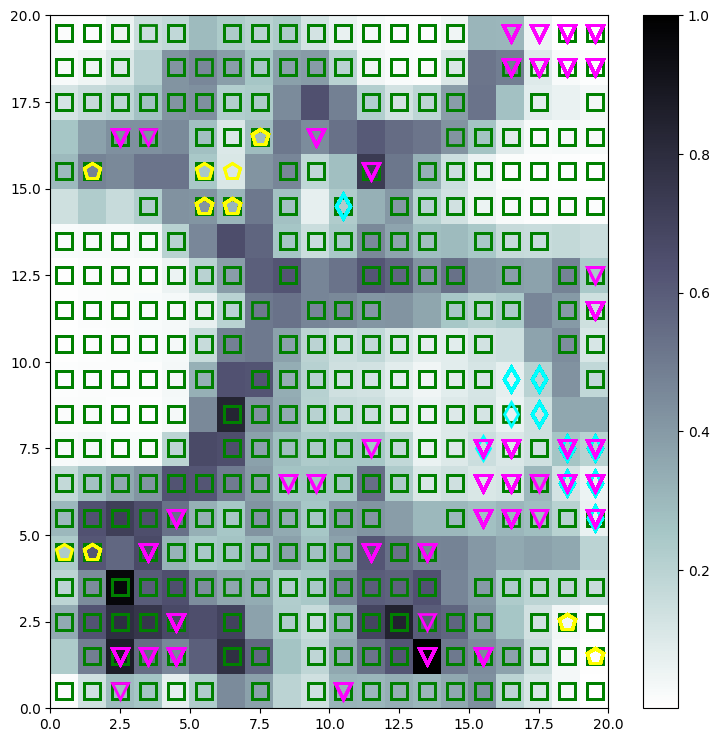

Percentage distribution (19720/380520)*100) at the densest point: 5.182382003574056%


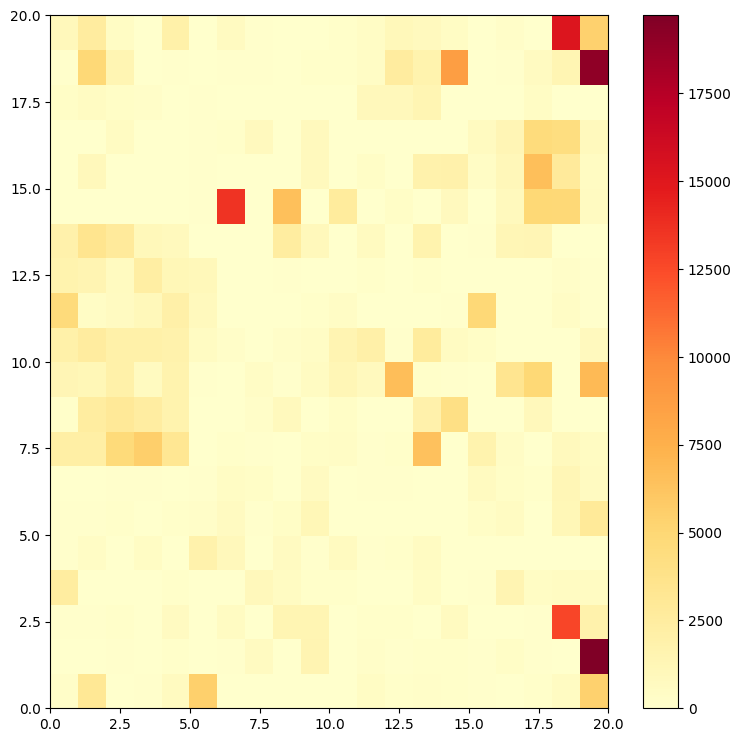

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label
1684828,2461738,8,7,1128,1581.0,661,0,141.000000,222.623321,1173,0,225.857143,430.098604,1.758384e+05,2.524643e+05,953120.0,113.0,2461738.0,3.516769e+05,4.253877e+05,1296104.0,365.0,2178214.0,3.630357e+05,2.899704e+05,953120.0,231546.0,172,152,3.249737,2.843519,0,1173,169.312500,317.731274,100953.162500,0,0,1,1,0,0,1,0,180.600000,141.000000,225.857143,8,1128,7,1581,8192,62872,5,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,1,0
1355867,115578266,16,14,451,795.0,440,0,28.187500,109.817557,795,0,56.785714,212.472687,3.985457e+06,4.879378e+06,10086492.0,49.0,115578266.0,7.705218e+06,4.152369e+06,10109312.0,268.0,110513961.0,8.501074e+06,3.767709e+06,10108812.0,1130.0,332,424,0.138434,0.121130,0,795,40.193548,160.785036,25851.827957,0,0,0,1,0,0,0,0,41.533333,28.187500,56.785714,16,451,14,795,8192,946,12,20,38581.454545,54322.325177,202368.0,22028.0,1.000813e+07,45809.813083,10086492.0,9890577.0,0,1,0
1785171,54920019,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,5.492002e+07,0.000000e+00,54920019.0,54920019.0,54920019.0,5.492002e+07,0.000000e+00,54920019.0,54920019.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,40,0,0.036417,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,279,-1,0,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,1,0
1659911,231,3,0,77,0.0,46,0,25.666667,23.459184,0,0,0.000000,0.000000,1.155000e+02,1.294005e+02,207.0,24.0,231.0,1.155000e+02,1.294005e+02,207.0,24.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,60,0,12987.012987,0.000000,0,46,30.750000,21.685248,470.250000,0,1,0,0,1,0,0,0,41.000000,25.666667,0.000000,3,77,0,0,256,-1,1,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,1,0
1259397,83,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,8.300000e+01,0.000000e+00,83.0,83.0,83.0,8.300000e+01,0.000000e+00,83.0,83.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,40,0,24096.385542,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,278,-1,0,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920268,16462,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1.646200e+04,0.000000e+00,16462.0,16462.0,16462.0,1.646200e+04,0.000000e+00,16462.0,16462.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,64,0,121.491921,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,225,-1,0,32,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,1,1
2237428,34243,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,3.424300e+04,0.000000e+00,34243.0,34243.0,34243.0,3.424300e+04,0.000000e+00,34243.0,34243.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,64,0,58.406098,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,225,-1,0,32,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,1,1
2113015,220,2,0,0,0.0

In [137]:
df_dataset = load_and_combine_datasets(FILES, DATA_PATH)
df_dataset = stratified_sample(df_dataset)
data, target = preprocess_data(df_dataset)
som = prepare_data_and_run_som(data, target)
plot_som_response(som,data,target,markers,colors)
display_activation_map(som,data)

display(df_dataset)

In [138]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from minisom import MiniSom

# Supponiamo di avere X come dati e y come etichette
# Selezioniamo i dati e le etichette correttamente
X = df_dataset.iloc[:, :-1].values  # Dati
y = df_dataset.iloc[:, -1].values  # Etichette

# Dividi il dataset in fold per la cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Esempio con 5 fold

# Definisci i parametri per MiniSom
som_shape = (20, 20)  # Esempio di dimensioni della mappa SOM
learning_rate = 1.2
sigma = 1.5
n_iterations = X_train.shape[0]


# Lista per memorizzare i report di ciascuna fold
report_list = []

# Loop per la cross-validation
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Inizializza e addestra il modello MiniSom
    som = MiniSom(som_shape[0], som_shape[1], X_train.shape[1], sigma=sigma, learning_rate=learning_rate)
    som.train_random(X_train, n_iterations)

    # Valuta il modello sui dati di test
    y_pred = classify(som, X_test)
    
    # Calcola il report di classificazione per la fold corrente
    report = classification_report(y_test, y_pred, digits=4)
    report_list.append(report)

# Stampare i report per ciascuna fold
for fold_idx, report in enumerate(report_list):
    print(f"Report for fold {fold_idx+1}:\n{report}")


TypeError: classify() missing 2 required positional arguments: 'training_data' and 'training_labels'